# Example Pythonic image-based single-cell profiling

The following is an example of performing image-based single-cell profiling using
Python tools without leaving the kernel for GUI-based interaction.

- load ExampleHuman images from the CellProfiler/examples repo
- segment nuclei with Cellpose (v3 or v4)
- extract features with cp_measure (classic CP-style measures)
- write incrementally to LanceDB:
    * images_raw: raw images as flattened lists (+ shape/dtype)
    * masks: segmentation masks as flattened lists (+ lineage to image & algo)
    * nuclei_features: per-object features (cp_measure)
    * run_log: per-file processing status

In [1]:
from __future__ import annotations

import pathlib
import shutil
import subprocess
import tempfile
from datetime import datetime, timezone
from pathlib import Path
from pprint import pp
from shutil import copy2, copytree
from typing import Any, Dict, List, Optional, Tuple

import cellpose
import imageio.v3 as iio
import lancedb
import numpy as np
import pandas as pd
import pyarrow as pa
from cellpose import models as cp_models

from serpula_rasa.image import (
    make_ome_arrow_row,
    reconstruct_tczyx_from_record,
    show_images_from_lance,
)
from serpula_rasa.meta import OME_ARROW_SCHEMA

try:
    from cellpose import version as CP_VERSION
except Exception:
    CP_VERSION = "unknown"
from cp_measure.bulk import get_core_measurements

REPO_URL = "https://github.com/CellProfiler/examples.git"
SUBPATH = "ExampleHuman"
DEST_DIR = pathlib.Path("data/ExampleHuman")

IMAGES_DIR = Path("data/ExampleHuman/images")
LANCE_DIR = Path("./data/lance_db")

TABLE_FEATURES = "compartment_nuclei"
TABLE_LOG = "run_log"
TABLE_IMAGES = "images"
TABLE_MASKS = "images"

MODEL_TYPE = "nuclei"  # Cellpose pretrained nuclei model
GPU = True  # set True if you have CUDA ready
MIN_OBJECTS_TO_SAVE = 1
CHANNELS = (0, 0)  # single-channel nuclei, compatible with Cellpose v3/v4

# remove the lance database to refresh on each run
if pathlib.Path(LANCE_DIR).is_dir():
    shutil.rmtree(LANCE_DIR)



Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.6 
platform:       	darwin 
python version: 	3.11.13 
torch version:  	2.8.0! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [2]:
# if we don't have the data already, create it
if not pathlib.Path(DEST_DIR).exists():
    DEST_DIR.mkdir(parents=True, exist_ok=True)

    with tempfile.TemporaryDirectory() as tmp:
        # Clone shallowly for speed
        subprocess.run(["git", "clone", "--depth", "1", REPO_URL, tmp], check=True)

        src = Path(tmp) / SUBPATH
        if not src.exists():
            raise FileNotFoundError(f"Subpath {SUBPATH!r} not found in the repo.")

        # Copy the CONTENTS of ExampleHuman directly under data/
        for entry in src.iterdir():
            target = DEST_DIR / entry.name
            if entry.is_dir():
                copytree(entry, target, dirs_exist_ok=True)
            else:
                copy2(entry, target)

pp(list(pathlib.Path(DEST_DIR).rglob("*")))

[PosixPath('data/ExampleHuman/images'),
 PosixPath('data/ExampleHuman/ExampleHuman.cppipe'),
 PosixPath('data/ExampleHuman/README.md'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d0.tif'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d1.tif'),
 PosixPath('data/ExampleHuman/images/AS_09125_050116030001_D03f00d2.tif')]


In [3]:
# create functions which can help us run the pipeline


def ndarray_to_list(arr: np.ndarray) -> List[float | int]:
    """
    Flatten to a Python list in C-order.
    Cast integer arrays to int (to keep sizes smaller) and float arrays to float.
    """
    if np.issubdtype(arr.dtype, np.integer):
        return arr.ravel(order="C").astype(np.int64, copy=False).tolist()
    else:
        return arr.ravel(order="C").astype(np.float32, copy=False).tolist()


def to_float01(img: np.ndarray) -> np.ndarray:
    """Scale image to float32 in [0,1] as cp_measure expects."""
    if img.dtype in (np.float32, np.float64):
        return np.clip(img.astype(np.float32, copy=False), 0.0, 1.0)
    img = img.astype(np.float32, copy=False)
    if np.issubdtype(img.dtype, np.integer):
        maxv = float(np.iinfo(img.dtype).max)
    else:
        maxv = float(img.max() or 1.0)
    if maxv != 0:
        img /= maxv
    return np.clip(img, 0.0, 1.0)


def list_images(root: Path) -> List[Path]:
    exts = (".tif", ".tiff", ".png", ".jpg", ".jpeg")
    return sorted([p for p in root.rglob("*") if p.suffix.lower() in exts])


# ---------- LanceDB helpers (lazy creation, schema-safe) ----------


def get_or_create_table(
    db: lancedb.db.LanceDBConnection, table_name: str, df_first_batch: pd.DataFrame
) -> lancedb.table.LanceTable:
    """
    Lazily create (or safely recreate) a table from the first batch df.
    If an incompatible table exists, drop and recreate with the new schema.
    """
    names = set(db.table_names())
    if table_name not in names:
        return db.create_table(table_name, df_first_batch)

    tbl = db.open_table(table_name)
    try:
        # quick compatibility probe
        tbl.add(df_first_batch.iloc[0:0])
        return tbl
    except Exception:
        print(f"[lancedb] Recreating table '{table_name}' with current schema.")
        db.drop_table(table_name)
        return db.create_table(table_name, df_first_batch)


def ensure_log_table(
    db: lancedb.db.LanceDBConnection, name: str
) -> lancedb.table.LanceTable:
    names = set(db.table_names())
    if name not in names:
        return db.create_table(
            name, pd.DataFrame([{"image": "", "status": "", "n_objects": 0}])
        ).delete("n_objects == 0")


# ---------- Cellpose v3/v4 compatibility ----------


def make_cellpose_model(model_type: str, gpu: bool) -> cellpose.models.CellposeModel:
    """
    Return a Cellpose model instance that works with Cellpose v3 or v4.
    """
    # v3 API
    if hasattr(cp_models, "Cellpose"):
        return cp_models.Cellpose(model_type=model_type, gpu=gpu)

    # v4 API
    if hasattr(cp_models, "CellposeModel"):
        try:
            return cp_models.CellposeModel(gpu=gpu, model_type=model_type)
        except TypeError:
            # alt signature in some builds
            return cp_models.CellposeModel(gpu=gpu, pretrained_model=model_type)

    raise RuntimeError("No compatible Cellpose model class found (v3 or v4).")


def cellpose_eval(
    model: cellpose.models.CellposeModel,
    img_f: np.ndarray,
    channels: Tuple[int, int] = (0, 0),
) -> Tuple[np.ndarray, float]:
    """
    Run model.eval and return (masks, diams_scalar).
    If Cellpose returns a vector of diameters, return its nanmean.
    If missing/unavailable, return NaN.
    """
    result = model.eval(img_f, channels=list(channels))

    # Unpack results across versions
    if isinstance(result, tuple):
        if len(result) >= 4:
            masks, flows, styles, diams = result[:4]
        elif len(result) == 3:
            masks, flows, styles = result
            diams = None
        elif len(result) == 2:
            masks, _ = result
            diams = None
        else:
            masks = result[0]
            diams = None
    else:
        masks, diams = np.asarray(result), None

    masks = np.asarray(masks)

    # Normalize diams to a scalar
    if diams is None:
        diam_scalar = float("nan")
    elif np.isscalar(diams):
        diam_scalar = float(diams)
    else:
        # handle list/ndarray cases
        arr = np.asarray(diams, dtype=np.float64)
        if arr.size == 0:
            print("NEGATIVE!")
            diam_scalar = float("nan")
        else:
            with np.errstate(all="ignore"):
                diam_scalar = float(np.nanmean(arr))

    return masks, diam_scalar


def gather_profiles() -> None:  # noqa: PLR0915, C901, PLR0912
    # Connect LanceDB + ensure log table
    db = lancedb.connect(str(LANCE_DIR))
    ensure_log_table(db, TABLE_LOG)
    log_tbl = db.open_table(TABLE_LOG)

    # Init Cellpose (v3 or v4) + measurement funcs
    model = make_cellpose_model(MODEL_TYPE, GPU)
    measurements = get_core_measurements()

    images = list_images(IMAGES_DIR)
    if not images:
        raise SystemExit(f"No images found under: {IMAGES_DIR.resolve()}")

    # --- We will build both struct columns in the same index order ---
    rows_combined = []  # each item will be:
    # {"ome-arrow_original": {...}, "ome-arrow_mask": {...}|None}

    for img_path in images:
        try:
            # Load image (keep dtype);
            # if multichannel HWC, pick channel 0 for demo parity
            img = iio.imread(img_path)
            if img.ndim == 3 and img.shape[-1] in (2, 3, 4):
                nuc_img = img[..., 0]
            else:
                nuc_img = img

            # ---------- Build original image struct ----------
            img_struct = make_ome_arrow_row(
                image_id=img_path.stem,
                col_name="ome-arrow_original",
                name=img_path.name,
                pixels=nuc_img,
                physical_size_xy_um=0.108,
                physical_size_z_um=1.0,
                physical_unit="µm",
                prefer_dimension_order_xyzct=False,  # 2D → "XYCT" hint
                acquisition_dt=datetime.now(timezone.utc),
            )

            # ---------- Segment + build mask struct (same index as image) ----------
            img_f = to_float01(nuc_img)
            masks, diams = cellpose_eval(model, img_f, channels=CHANNELS)

            mask_struct = make_ome_arrow_row(
                image_id=img_path.stem,
                col_name="ome-arrow_mask",
                name=f"{img_path.name} (mask)",
                pixels=masks.astype(np.uint16, copy=False),
                physical_size_xy_um=0.108,
                physical_size_z_um=1.0,
                physical_unit="µm",
                prefer_dimension_order_xyzct=False,
                acquisition_dt=datetime.now(timezone.utc),
            )

            # Collect a single row with both structs (aligned by index)
            rows_combined.append(
                {
                    "image_filename": img_path.name,
                    "ome-arrow_original": img_struct["ome-arrow_original"],
                    "ome-arrow_mask": mask_struct["ome-arrow_mask"],
                }
            )

            # ---------- Optional: keep your legacy masks/features tables ----------
            labels = np.unique(masks)
            labels = labels[labels > 0]
            n_obj = int(labels.size)

            mask_record = pd.DataFrame(
                [
                    {
                        "filename": img_path.name,
                        "algo_name": "cellpose",
                        "algo_version": CP_VERSION,
                        "model_type": MODEL_TYPE,
                        "channels": str(CHANNELS),
                        "n_objects": n_obj,
                        "height": int(masks.shape[0]),
                        "width": int(masks.shape[1]),
                        "dtype": "int32",
                        "image": masks.astype(np.int32, copy=False)
                        .ravel(order="C")
                        .tolist(),
                    }
                ]
            )
            get_or_create_table(db, TABLE_MASKS, mask_record)

            if n_obj < MIN_OBJECTS_TO_SAVE:
                log_tbl.add(
                    [
                        {
                            "image_filename": str(img_path),
                            "status": "no_objects",
                            "n_objects": n_obj,
                        }
                    ]
                )
                print(f"- {img_path.name}: no objects")
                continue

            feature_arrays: Dict[str, np.ndarray] = {}
            for _, fn in measurements.items():
                res = fn(masks, img_f)
                feature_arrays.update(res)

            rows = []
            for i, obj_id in enumerate(labels, start=0):
                row = {
                    "image_filename": img_path.name,
                    "nuclei_object_number": int(obj_id),
                }
                for feat_name, arr in feature_arrays.items():
                    if i < len(arr):
                        val = arr[i]
                        try:
                            row[feat_name] = (
                                float(val)
                                if np.ndim(val) == 0
                                else float(np.array(val).item())
                            )
                        except Exception:
                            row[feat_name] = float("nan")
                rows.append(row)
            df_features = pd.DataFrame(rows)
            get_or_create_table(db, TABLE_FEATURES, df_features)

            log_tbl.add([{"image": str(img_path), "status": "ok", "n_objects": n_obj}])
            print(f"✓ {img_path.name}: {n_obj} objects")

        except Exception as ex:
            # If segmentation or anything else fails,
            # still store original image row with mask=None
            try:
                if "img_struct" in locals():
                    rows_combined.append(
                        {
                            "ome-arrow_original": img_struct["ome-arrow_original"],
                            # nullable struct column will accept None
                            "ome-arrow_mask": None,
                        }
                    )
            except Exception:
                pass

            log_tbl.add(
                [
                    {
                        "image": str(img_path),
                        "status": f"error: {type(ex).__name__}: {ex}",
                        "n_objects": 0,
                    }
                ]
            )
            print(f"✗ {img_path.name}: {ex}")

    # ---------- Materialize a table with both structs + filename ----------
    struct_type = OME_ARROW_SCHEMA.field(0).type
    schema_three_cols = pa.schema(
        [
            pa.field("image_filename", pa.string()),  # top-level column
            pa.field("ome-arrow_original", struct_type),
            pa.field("ome-arrow_mask", struct_type),
        ]
    )

    # Each row now carries filename + both struct values
    arrow_tbl = pa.Table.from_pylist(rows_combined, schema=schema_three_cols)

    # ---------- Create/replace Lance table ----------
    if TABLE_IMAGES in set(db.table_names()):
        db.drop_table(TABLE_IMAGES)
    img_tbl = db.create_table(TABLE_IMAGES, data=arrow_tbl)
    print(f"[ome-arrow] stored {img_tbl.count_rows()} row(s) in Lance (images + masks)")


def add_ome_crops_to_nuclei_table(  # noqa: PLR0913
    *,
    db_path: Path,
    images_table: str = "images",
    nuclei_table: str = "compartment_nuclei",
    image_struct_col: str = "ome-arrow_original",  # where the full image sits
    out_crop_col: str = "ome-arrow_crop",  # new struct column to add
    image_col: str = "filename",  # top-level filename in images table
    nuclei_col: str = "image_filename",  # column in nuclei table
    bbox_min_x: str = "BoundingBoxMinimum_X",
    bbox_max_x: str = "BoundingBoxMaximum_X",
    bbox_min_y: str = "BoundingBoxMinimum_Y",
    bbox_max_y: str = "BoundingBoxMaximum_Y",
    pad: int = 0,  # optional padding (pixels) around the bbox
    clamp_to_image: bool = True,
    prefer_dimension_order_xyzct: bool = False,  # 2D → "XYCT" hint
) -> lancedb.table.LanceTable:
    """
    For each nucleus row with a bounding box, create an ome-arrow crop from the
    corresponding source image and add it as a new struct column to the nuclei table.
    Re-creates the nuclei table with an appended column in one shot.

    Requirements:
      - The images table has one row per image and includes:
          • a top-level string column `image_col` (e.g., 'filename')
          • a struct column `image_struct_col` (e.g., 'ome-arrow_original')
      - The nuclei table has per-object rows with:
          • `nuclei_col` pointing to the source image filename
          • bounding box columns (min/max X/Y) in pixel coordinates

    Returns
    -------
    LanceTable
        The (re)created nuclei table with an extra ome-arrow crop column.
    """
    db = lancedb.connect(str(db_path))

    # ---------- 1) Load images table: build a lookup by filename ----------
    img_tbl = db.open_table(images_table)
    imgs_arrow = img_tbl.to_arrow()  # whole table
    # Select only what we need
    imgs_arrow = imgs_arrow.select([image_col, image_struct_col])

    # Build filename -> ome-arrow record mapping
    image_by_name: Dict[str, Dict[str, Any]] = {}
    for i in range(len(imgs_arrow)):
        fname = imgs_arrow[image_col][i].as_py()
        rec = imgs_arrow[image_struct_col][i].as_py()
        image_by_name[fname] = rec

    # ---------- 2) Load nuclei table ----------
    nuc_tbl = db.open_table(nuclei_table)
    nuc_arrow = nuc_tbl.to_arrow()  # keep all columns (we'll append one)

    # ---------- 3) Create crop structs aligned by row index ----------
    struct_type = OME_ARROW_SCHEMA.field(0).type  # reuse canonical struct type
    crops: List[Optional[Dict[str, Any]]] = []

    for i in range(len(nuc_arrow)):
        row = nuc_arrow.slice(i, 1)
        # Read filename & bbox for this nucleus
        fname = row[nuclei_col][0].as_py()
        xmin = row[bbox_min_x][0].as_py()
        xmax = row[bbox_max_x][0].as_py()
        ymin = row[bbox_min_y][0].as_py()
        ymax = row[bbox_max_y][0].as_py()

        # Missing filename or image? → no crop
        src = image_by_name.get(fname)
        if src is None:
            crops.append(None)
            continue

        # Reconstruct (T,C,Z,Y,X).
        # Our images are typically 2D single-channel → (1,1,1,Y,X)
        arr = reconstruct_tczyx_from_record(src)
        slab = arr[0, 0]  # (Z, Y, X) or (1, Y, X)

        # If you have Z-stacks, pick a policy; here take z=0
        plane = slab[0]

        H, W = plane.shape[0], plane.shape[1]

        # Convert bbox to ints and pad
        x0 = int(np.floor(xmin)) - pad
        x1 = int(np.ceil(xmax)) + pad
        y0 = int(np.floor(ymin)) - pad
        y1 = int(np.ceil(ymax)) + pad

        if clamp_to_image:
            x0 = max(0, x0)
            y0 = max(0, y0)
            x1 = min(W, x1)
            y1 = min(H, y1)

        # Validate bbox
        if x1 <= x0 or y1 <= y0:
            crops.append(None)
            continue

        crop = plane[y0:y1, x0:x1]  # (h, w), numeric

        # Build the ome-arrow struct for the crop
        # Use the nucleus row index or a composite for uniqueness
        crop_id = f"{fname}__row{i}"
        crop_struct = make_ome_arrow_row(
            image_id=crop_id,
            col_name=out_crop_col,
            name=f"{fname} [y{x0}:{x1}, x{y0}:{y1}]",
            pixels=crop,
            physical_size_xy_um=src["pixels_meta"]["physical_size_x"],
            physical_size_z_um=src["pixels_meta"]["physical_size_z"],
            physical_unit=src["pixels_meta"]["physical_size_x_unit"],
            prefer_dimension_order_xyzct=prefer_dimension_order_xyzct,
            acquisition_dt=datetime.now(timezone.utc),
        )
        crops.append(crop_struct[out_crop_col])

    # ---------- 4) Append the new struct column and (re)create Lance table ----------
    crop_array = pa.array(crops, type=struct_type)  # nullable ok
    new_nuc_arrow = nuc_arrow.append_column(out_crop_col, crop_array)

    # Recreate the table atomically (simple & robust)
    if nuclei_table in set(db.table_names()):
        db.drop_table(nuclei_table)
    new_tbl = db.create_table(nuclei_table, data=new_nuc_arrow)

    return new_tbl

In [4]:
%%time
# run the pipeline and show the time duration
gather_profiles()

model_type argument is not used in v4.0.1+. Ignoring this argument...
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used
/Users/buntend/Documents/work/serpula_rasa/.venv/lib/python3.11/site-packages/cp_measure/core/measureobjectintensitydistribution.py:279: RuntimeWarning: invalid value encountered in divide
  radial_means = numpy.ma.masked_array(radial_values / pixel_count, mask)
channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


✓ AS_09125_050116030001_D03f00d0.tif: 329 objects
[lancedb] Recreating table 'images' with current schema.


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


✓ AS_09125_050116030001_D03f00d1.tif: 22 objects
[lancedb] Recreating table 'images' with current schema.
✓ AS_09125_050116030001_D03f00d2.tif: 307 objects
[ome-arrow] stored 3 row(s) in Lance (images + masks)
CPU times: user 8.06 s, sys: 1.9 s, total: 9.95 s
Wall time: 18.1 s


In [5]:
%%time
# add nuclei object image crops as ome-arrow images
_ = add_ome_crops_to_nuclei_table(
    db_path=LANCE_DIR,
    images_table=TABLE_IMAGES,  # your images table
    nuclei_table=TABLE_FEATURES,  # if your nuclei/objects live here
    image_struct_col="ome-arrow_original",  # the source image struct
    out_crop_col="ome-arrow_crop",  # new column to add
    image_col="image_filename",  # in images table
    nuclei_col="image_filename",  # in nuclei table
)

CPU times: user 1.32 s, sys: 66.2 ms, total: 1.38 s
Wall time: 1.35 s


In [6]:
db = lancedb.connect(LANCE_DIR)
db.table_names()

['compartment_nuclei', 'images', 'run_log']

In [7]:
# show nuclei features
db.open_table("run_log").to_pandas().iloc[0].to_dict()

{'image': 'data/ExampleHuman/images/AS_09125_050116030001_D03f00d0.tif',
 'status': 'ok',
 'n_objects': 329}

In [8]:
# show nuclei features
db.open_table("compartment_nuclei").to_pandas()

,image_filename,nuclei_object_number,RadialDistribution_FracAtD_1of4,RadialDistribution_MeanFrac_1of4,RadialDistribution_RadialCV_1of4,RadialDistribution_FracAtD_2of4,RadialDistribution_MeanFrac_2of4,RadialDistribution_RadialCV_2of4,RadialDistribution_FracAtD_3of4,RadialDistribution_MeanFrac_3of4,...,Granularity_8,Granularity_9,Granularity_10,Granularity_11,Granularity_12,Granularity_13,Granularity_14,Granularity_15,Granularity_16,ome-arrow_crop
0,AS_09125_050116030001_D03f00d0.tif,1,0.066951,1.121424,0.014845,0.251369,1.122783,0.065710,0.355143,1.081572,...,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,79.610468,81.649421,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
1,AS_09125_050116030001_D03f00d0.tif,2,0.088487,1.052997,0.057045,0.252956,1.075065,0.083051,0.382765,1.059279,...,70.884871,74.119885,75.737394,77.354901,77.354901,77.354901,77.354901,77.354901,77.354901,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
2,AS_09125_050116030001_D03f00d0.tif,3,0.219917,1.172891,0.052101,0.288382,1.153527,0.069755,0.360996,0.962656,...,73.443983,73.443983,73.443983,75.103735,75.103735,75.103735,75.103735,76.763486,76.763486,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
3,AS_09125_050116030001_D03f00d0.tif,4,0.041842,1.359866,0.017751,0.258727,1.201234,0.049485,0.396138,1.029958,...,82.297598,82.297598,82.297598,83.906908,83.906908,83.906908,83.906908,83.906908,85.516217,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
4,AS_09125_050116030001_D03f00d0.tif,5,0.079810,1.140150,0.057289,0.221028,1.105139,0.033416,0.374818,1.041160,...,69.023322,69.023322,70.845480,72.667639,72.667639,72.667639,72.667639,74.489796,74.489796,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,AS_09125_050116030001_D03f00d0.tif,325,0.110497,1.187845,0.019797,0.267229,1.149084,0.047890,0.346612,1.064595,...,83.745275,84.995638,87.496365,88.746729,88.746729,88.746729,88.746729,88.746729,88.746729,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
325,AS_09125_050116030001_D03f00d0.tif,326,0.166237,1.246778,0.051735,0.201460,1.208763,0.030413,0.416237,1.040593,...,85.824742,85.824742,87.113402,88.402062,88.402062,88.402062,88.402062,88.402062,88.402062,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
326,AS_09125_050116030001_D03f00d0.tif,327,0.165862,1.227375,0.048544,0.245974,1.137631,0.071380,0.326490,1.006676,...,83.615137,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670,85.104670,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
327,AS_09125_050116030001_D03f00d0.tif,328,0.062563,1.126141,0.081081,0.253297,1.139838,0.102894,0.402435,1.034833,...,79.303347,82.955699,84.173149,85.390599,85.390599,86.608049,86.608049,86.608049,86.608049,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."


In [9]:
# show the images table
db.open_table("images").to_pandas()

,image_filename,ome-arrow_original,ome-arrow_mask
0,AS_09125_050116030001_D03f00d0.tif,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'...","{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
1,AS_09125_050116030001_D03f00d1.tif,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'...","{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."
2,AS_09125_050116030001_D03f00d2.tif,"{'type': 'ome.arrow', 'version': '0.0.1', 'id'...","{'type': 'ome.arrow', 'version': '0.0.1', 'id'..."


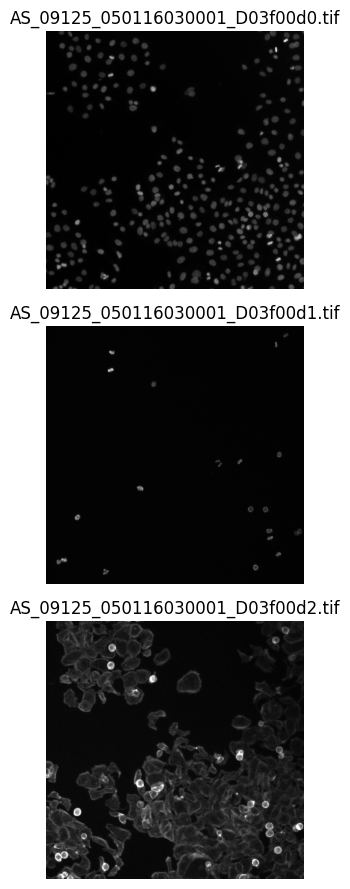

In [10]:
# show the originals
show_images_from_lance(
    db_path=LANCE_DIR,
    table_name="images",
    col_name="ome-arrow_original",
    max_images=4,
    pick="first",
    cmap="gray",
    cols=1,
)

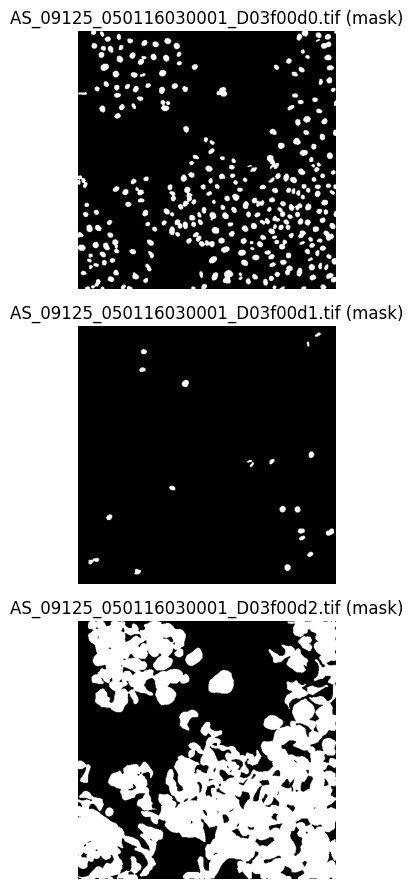

In [11]:
# show the masks
show_images_from_lance(
    db_path=LANCE_DIR,
    table_name="images",
    col_name="ome-arrow_mask",
    max_images=4,
    pick="first",
    cmap="gray",
    vmin=0,
    vmax=1,
    cols=1,
)

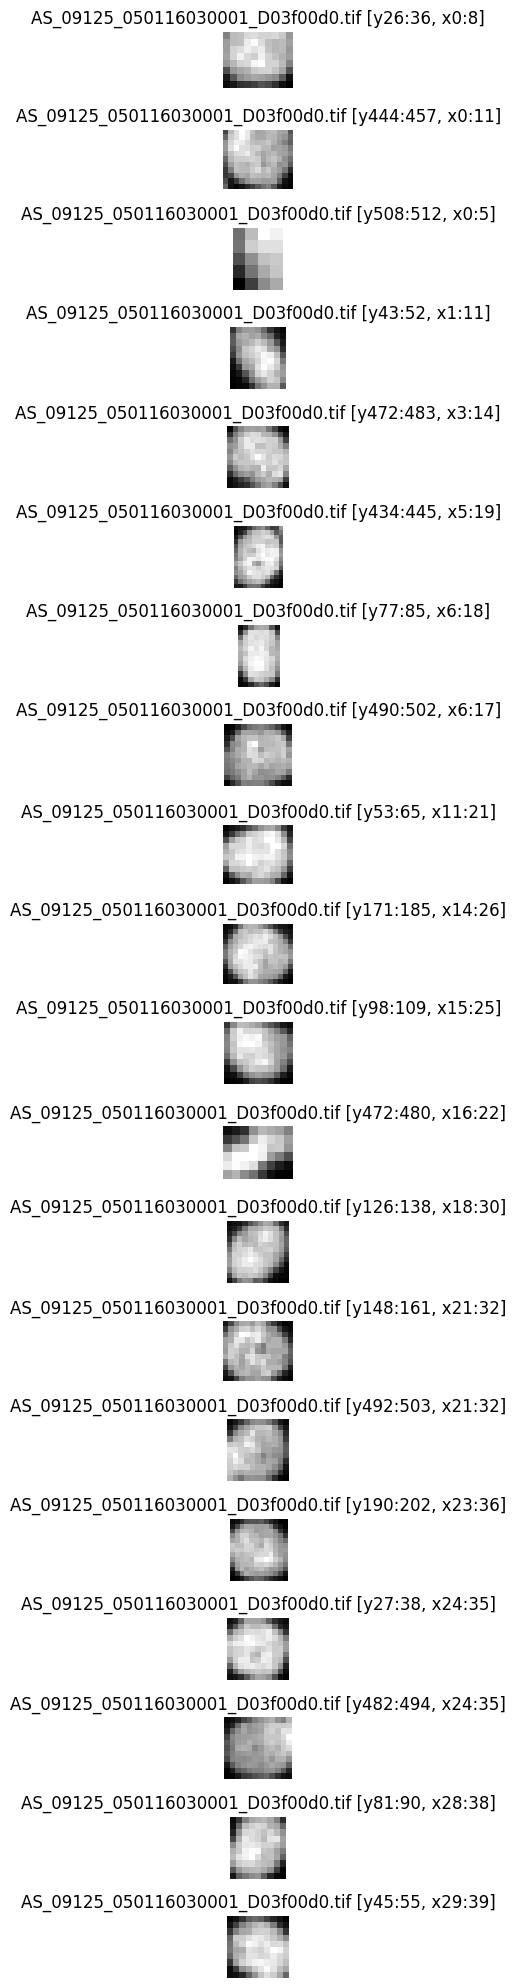

In [12]:
# show the crops
show_images_from_lance(
    db_path=LANCE_DIR,
    table_name="compartment_nuclei",
    col_name="ome-arrow_crop",
    max_images=20,
    pick="first",
    cmap="gray",
    base_size=1,
    cols=1,
)